In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.features.transforming import map_by_group
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_crosscorr_matrix,
    plot_averages_with_ci,
    plot_averages_with_ci_plt,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_table(
        "Merged_and_Labeled_Data",
        exclude_trials_with_measurement_problems=True,
    )

df = df.drop(["heart_rate", "pupil"]).rename(
    {
        "rating": "pain_rating",
        # NOTE: using the non-causal data columns here
        "heart_rate_exploratory": "heart_rate",
        "pupil_exploratory": "pupil_diameter",
        # eda tonic and phasic are already non-causally transformed
    }
)

In [5]:
signals = [
    "temperature",
    "pain_rating",
    "heart_rate",
    "pupil_diameter",
    "eda_tonic",
    "eda_phasic",
]


## Averaged trials over stimulus seeds with confidence intervals

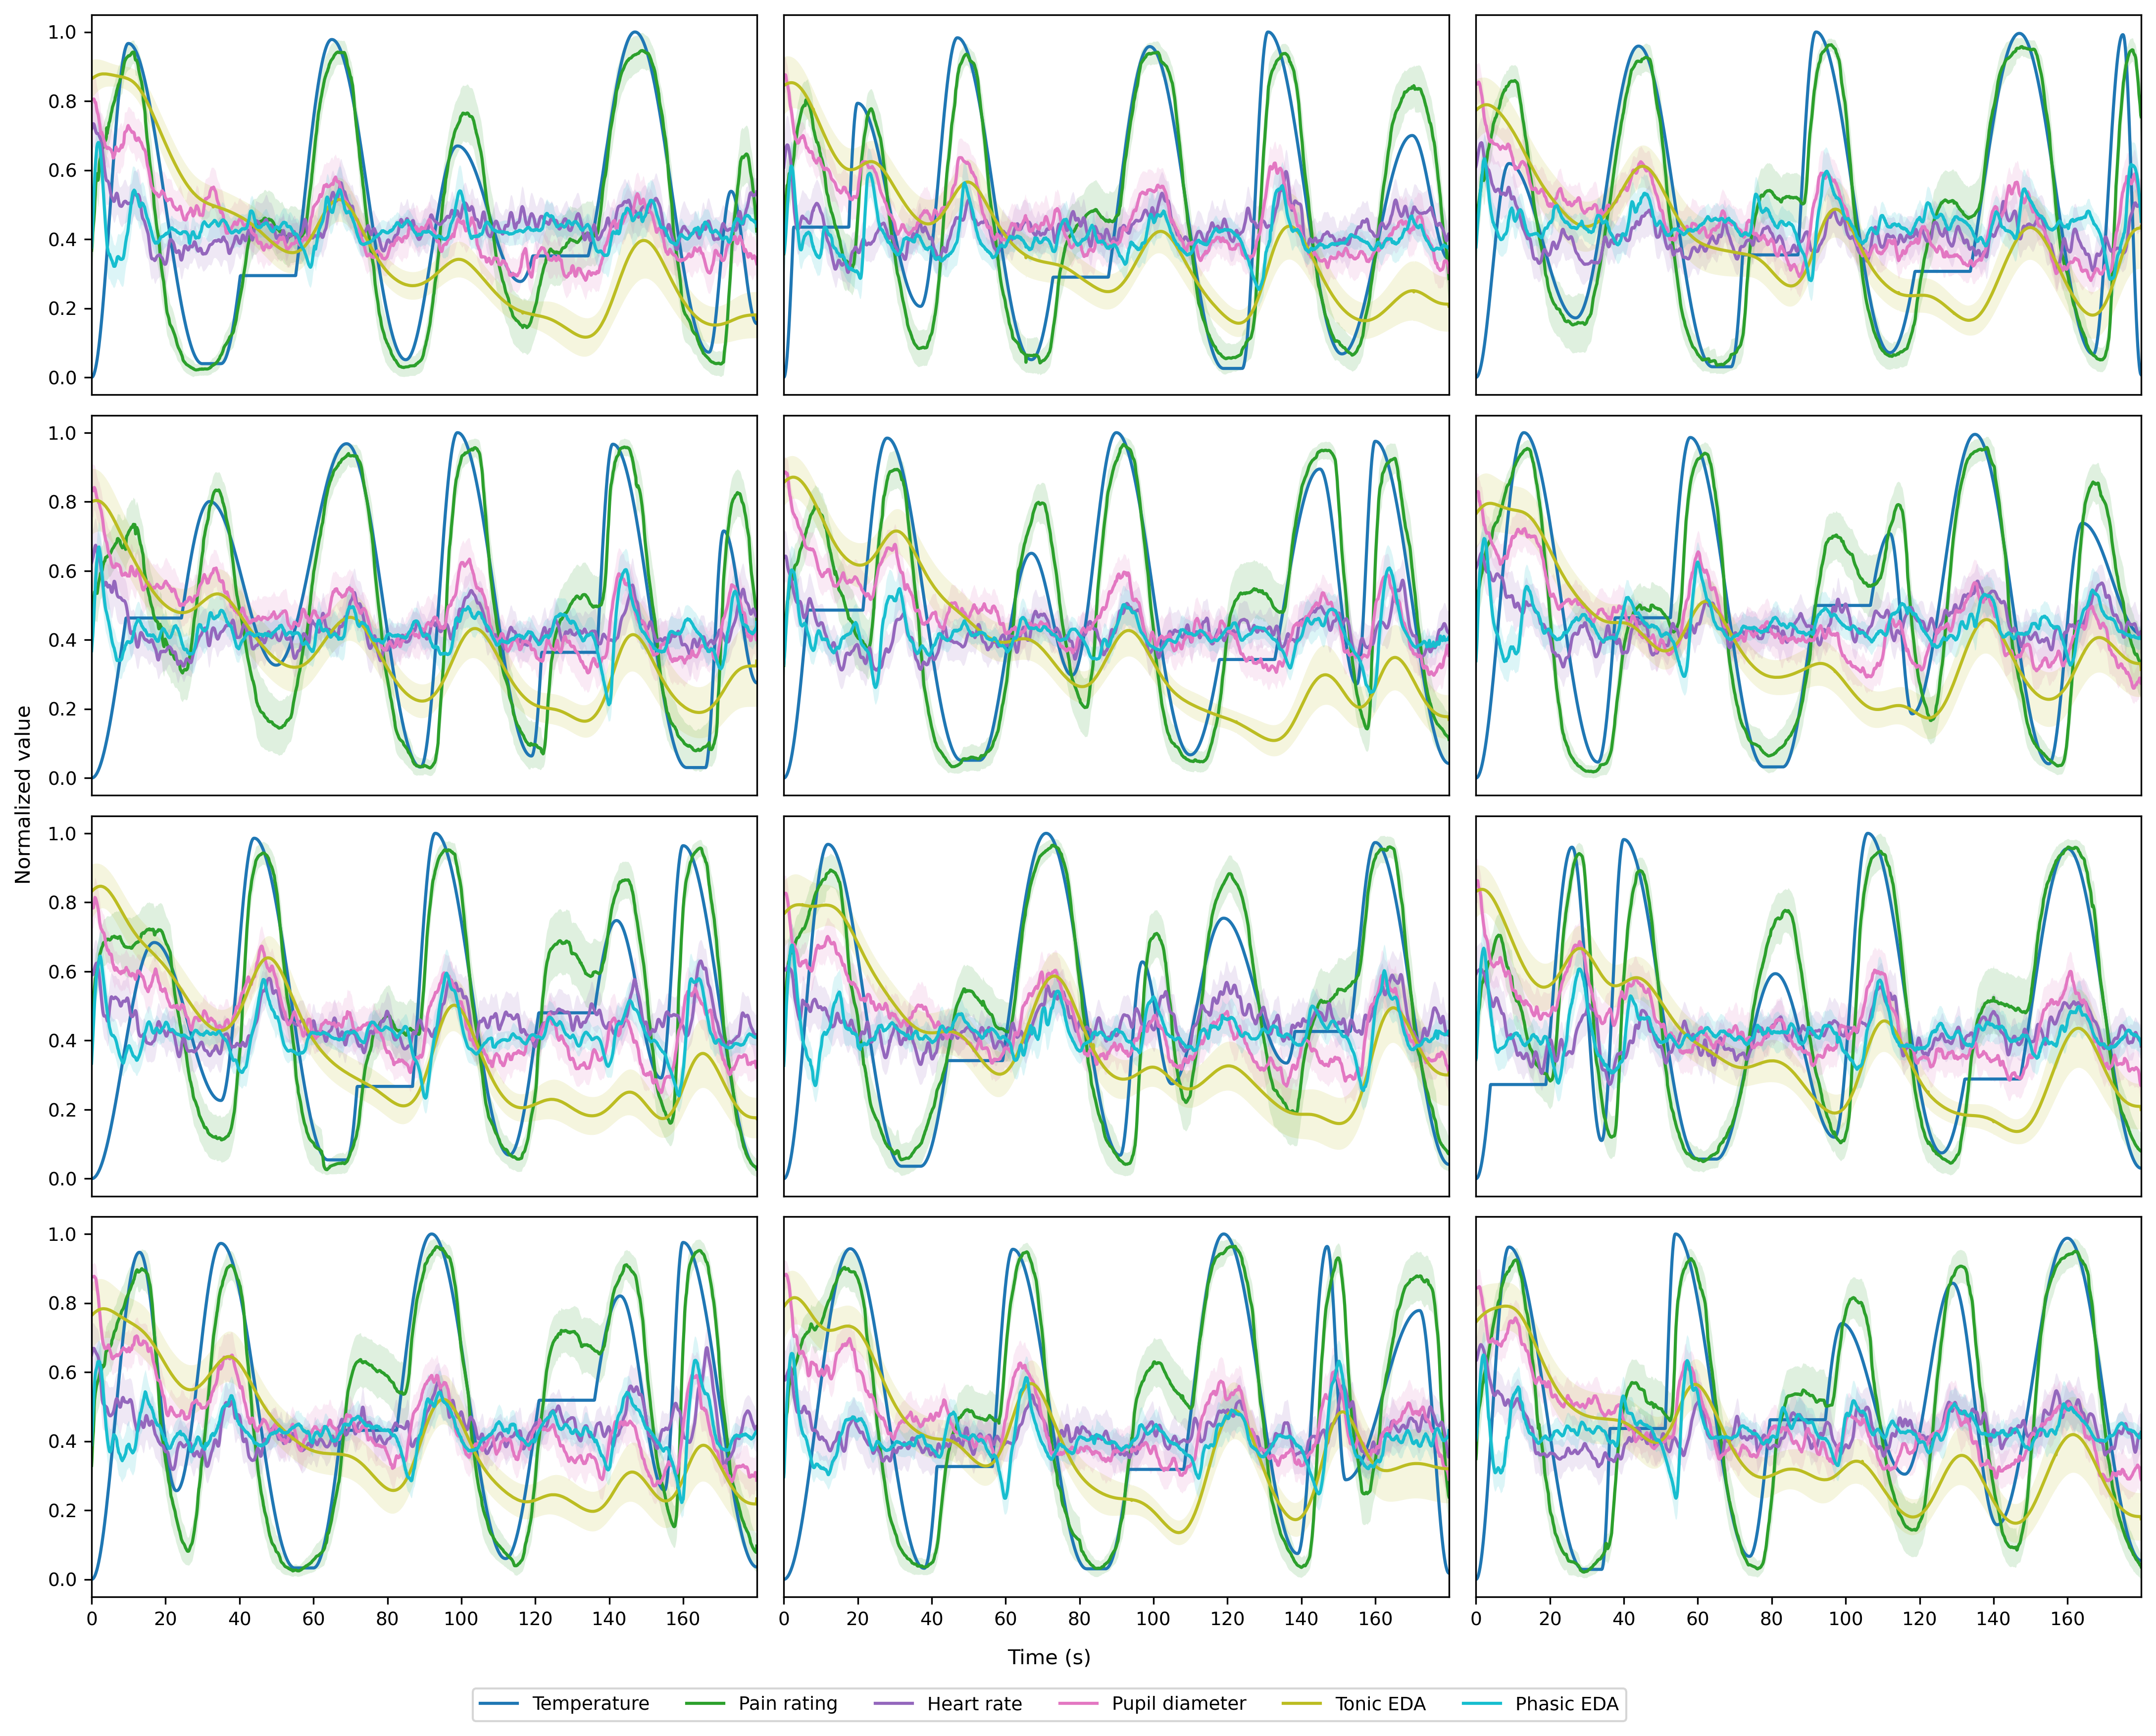

In [6]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plots = plot_averages_with_ci_plt(
    averges_with_ci,
    signals,
)

In [7]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

plots.savefig(FIGURE_DIR / "averages_over_stimulus_seeds.png")

In [8]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

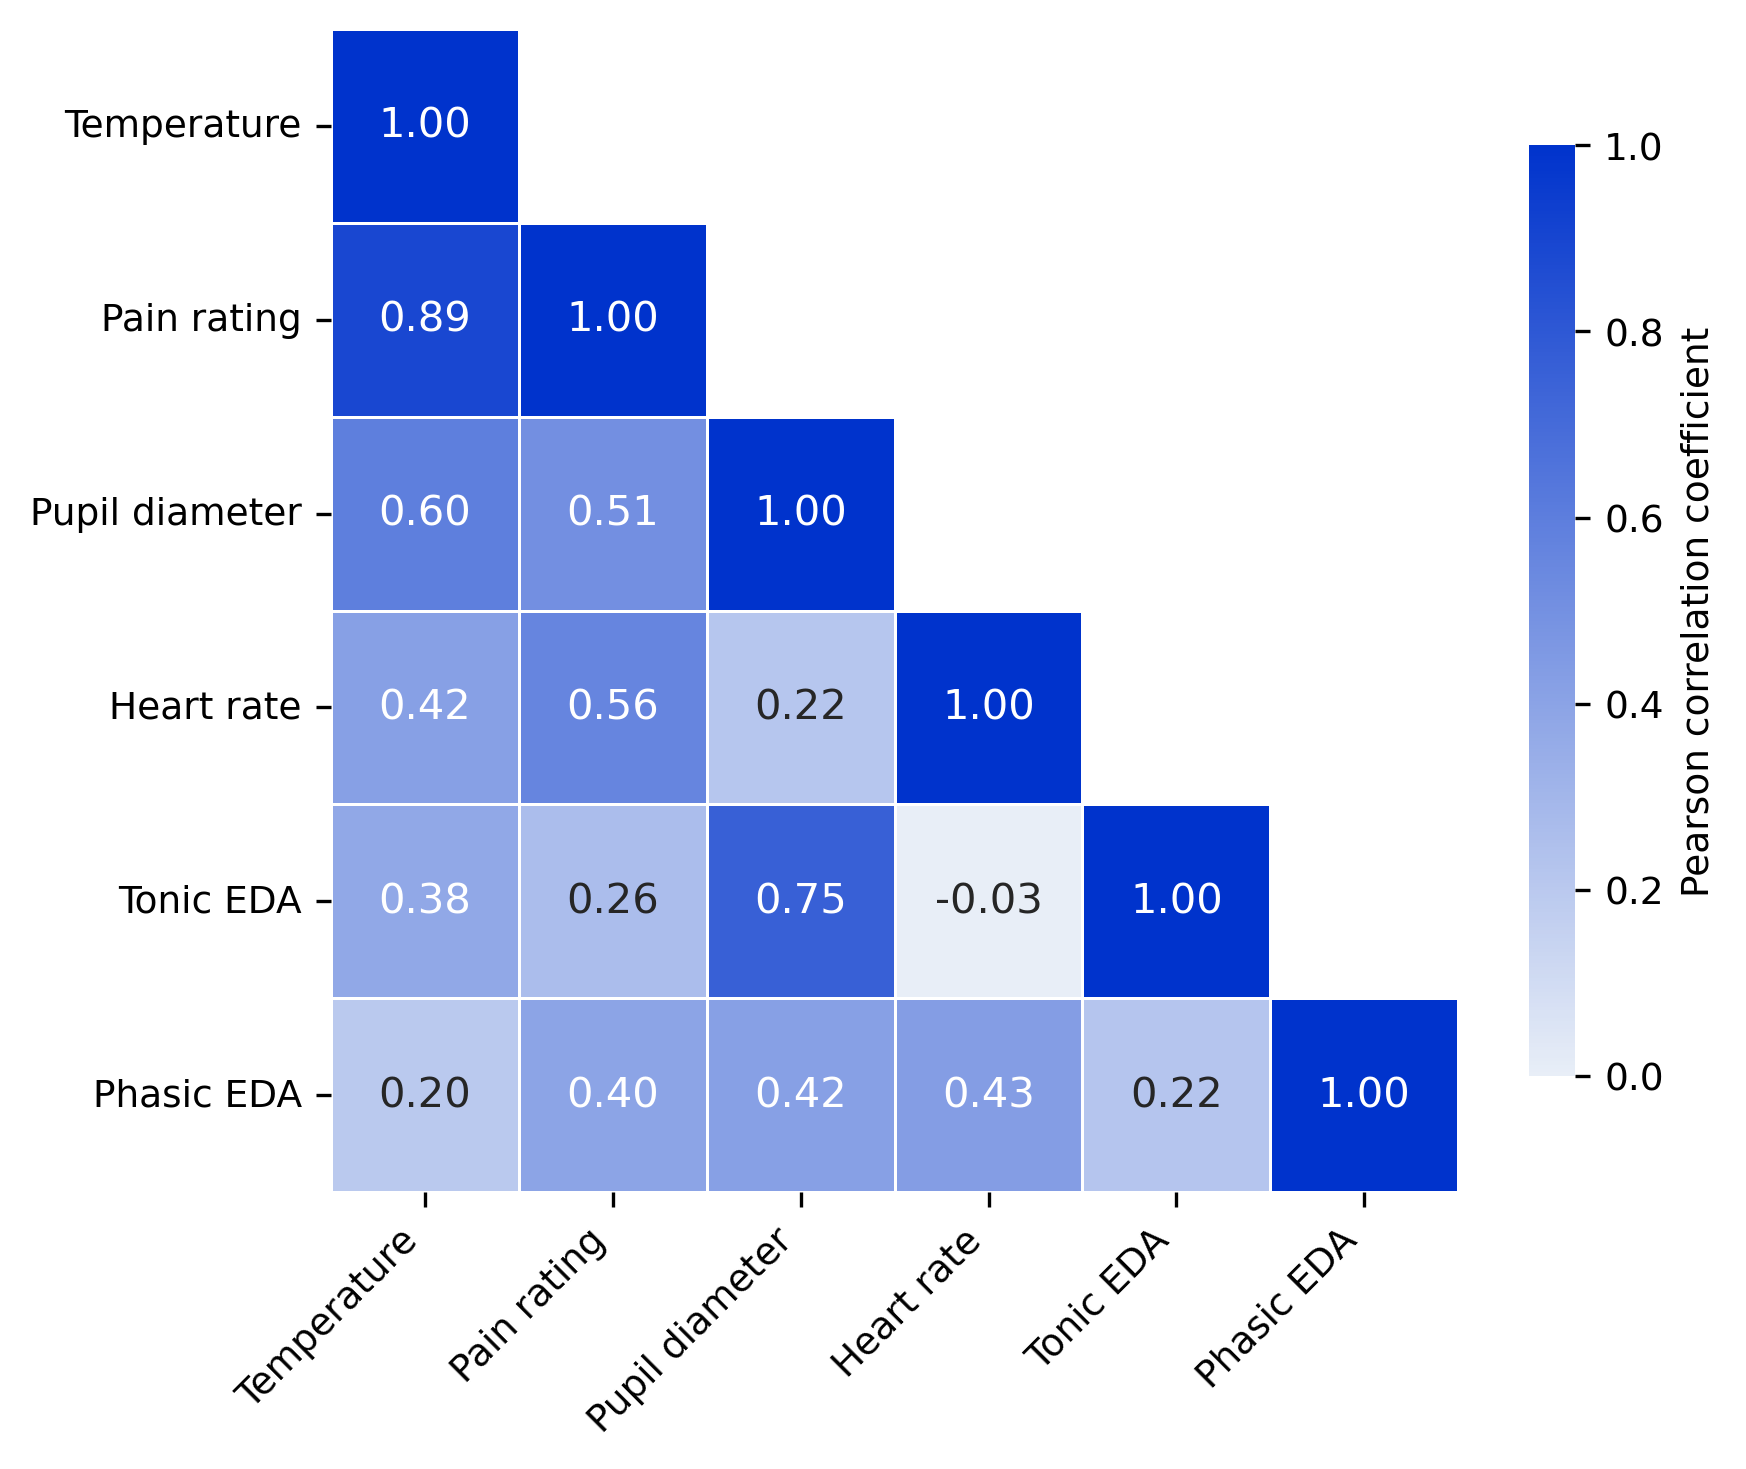

In [9]:
# without first 20 seconds
correlation_heatmap = plot_correlation_heatmap(averages)

In [10]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)

In [11]:
# Sample code for correlations for each stimulus seed with standard deviation
correlations = []
for group in averages.group_by("stimulus_seed"):
    corr = group[1].select(pl.corr("avg_pupil_diameter", "avg_eda_phasic")).item()
    correlations.append(corr)
correlations = np.array(correlations)
correlations.mean().round(2), correlations.std().round(2)


(np.float64(0.46), np.float64(0.04))

## Cross correlation lags of grand means

In [12]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="temperature",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ temperature      ┆ pupil_diameter ┆ -0.125    ┆ 0.29756  │
│ temperature      ┆ pain_rating    ┆ -1.008333 ┆ 0.335307 │
│ temperature      ┆ eda_tonic      ┆ -1.058333 ┆ 0.596459 │
│ temperature      ┆ heart_rate     ┆ -1.758333 ┆ 1.362264 │
│ temperature      ┆ eda_phasic     ┆ -2.316667 ┆ 1.034274 │
└──────────────────┴────────────────┴───────────┴──────────┘

In [13]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="pain_rating",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_rating_results.json")
cross_corr_results

shape: (5, 4)
┌──────────────────┬────────────────┬───────────┬──────────┐
│ reference_signal ┆ target_signal  ┆ mean_lag  ┆ std_lag  │
│ ---              ┆ ---            ┆ ---       ┆ ---      │
│ str              ┆ str            ┆ f64       ┆ f64      │
╞══════════════════╪════════════════╪═══════════╪══════════╡
│ pain_rating      ┆ temperature    ┆ 1.008333  ┆ 0.335307 │
│ pain_rating      ┆ pupil_diameter ┆ 0.316667  ┆ 0.519348 │
│ pain_rating      ┆ eda_tonic      ┆ -0.15     ┆ 0.236291 │
│ pain_rating      ┆ heart_rate     ┆ -0.341667 ┆ 0.526717 │
│ pain_rating      ┆ eda_phasic     ┆ -0.441667 ┆ 0.41725  │
└──────────────────┴────────────────┴───────────┴──────────┘

In [14]:
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight"
)